## Notebook to explore the performance of different toy models of superposition across various sparsity levels

Toy models: 
1. Simple - ReLU(x)
2. Simple - Relu(x) (handcoded, Lucius)
3. Apollo: Residual + Embedding
4. Anthropic: abs(x)

Sparsity levels: 



In [5]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

In [7]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [8]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

## 1. Simple ReLU

MLP that computes: $y = ReLU(x)$

Architecture: 100 input features for 50 neurons in a single layer. 

Loss function: MSE (not weighted for now)

Input: 100 features with a sparsity S =0.99, meaning that any given feature has p = 0.01 of being active, where `x = rand(-1,1)`

In [9]:
# 1. Training functions
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [13]:
layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

relu_cis = Cis(simple_relu_cfg, device=device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 100
optimizer = t.optim.Adam(relu_cis.parameters())

losses = train(
    relu_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.0018836917588487267,
 0.0015871297800913453,
 0.001702902838587761,
 0.0015841966960579157,
 0.0011276653967797756,
 0.0013304215390235186,
 0.000994030386209488,
 0.0008906899020075798,
 0.0009504006593488157,
 0.001011736341752112,
 0.0009113156120292842,
 0.0008313126745633781,
 0.0010183973936364055,
 0.0010326820192858577,
 0.0009772139601409435,
 0.0008562650182284415,
 0.0009049185900948942,
 0.0008146540494635701,
 0.001034269342198968,
 0.0010723957093432546,
 0.0010222364217042923,
 0.0010526032419875264,
 0.0006687812856398523,
 0.0008881380199454725,
 0.0006852804217487574,
 0.0006844516028650105,
 0.0009998686145991087,
 0.0009142489288933575,
 0.0008744957740418613,
 0.00093922606902197,
 0.0011711400002241135,
 0.0009419156122021377,
 0.000908686954062432,
 0.0008769109845161438,
 0.0009739685337990522,
 0.001011369633488357,
 0.0009804910514503717,
 0.0010273279622197151,
 0.0008864720584824681,
 0.0007801511092111468,
 0.000978192314505577,
 0.0009590987465344369,
 

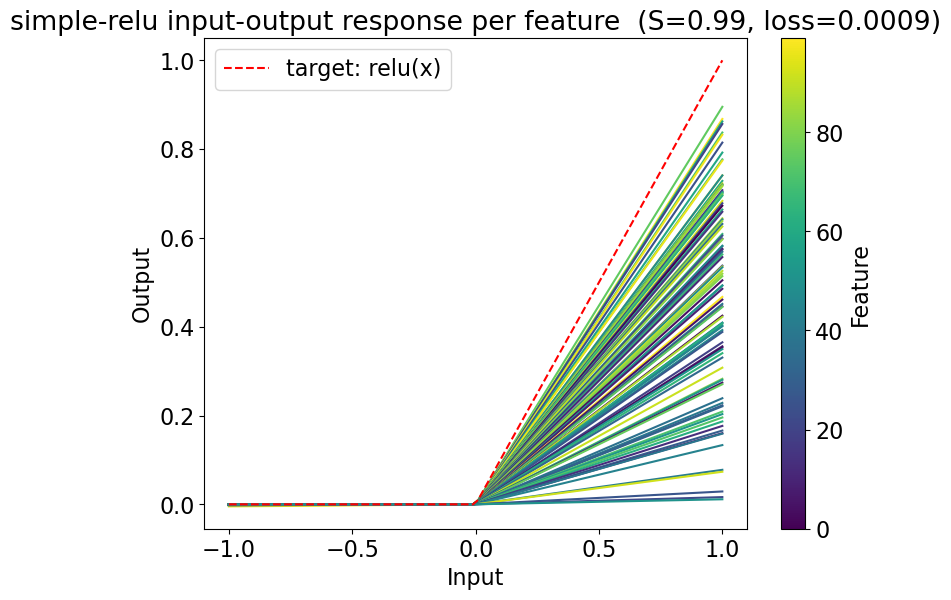

In [14]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"simple-relu input-output response per feature  (S={feat_sparsity}, loss={losses[-1]:.4f})")
ax.legend()

In [ ]:
"""Plot loss vs sparsity for this model trained at S = 0.99"""

